Fetched data shape: (18292, 7)


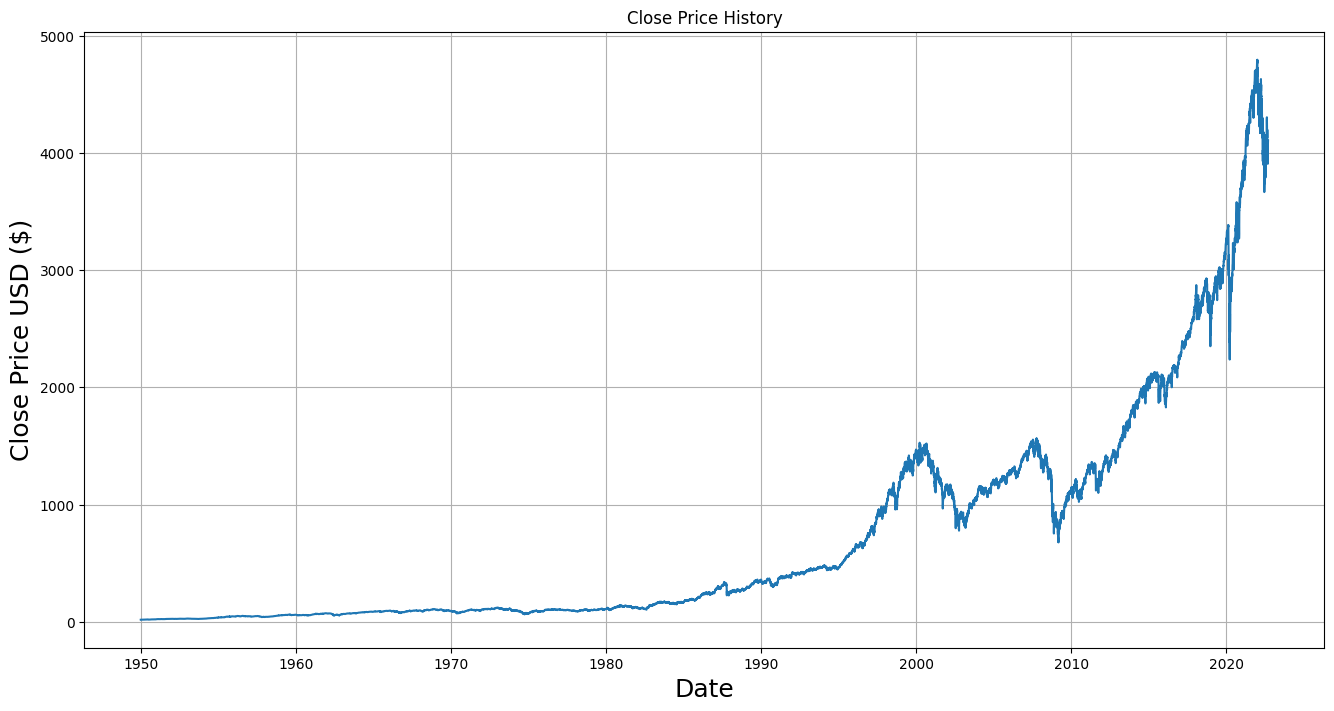

Epoch 1/5


c:\Users\Sai\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - loss: 8.0717e-04
Epoch 2/5
456/456 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - loss: 1.1485e-05
Epoch 3/5
456/456 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - loss: 1.0021e-05
Epoch 4/5
456/456 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - loss: 7.6674e-06
Epoch 5/5
456/456 ━━━━━━━━━━━━━━━━━━━━ 28s 61ms/step - loss: 8.6375e-06
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
Test RMSE: 93.24435729012488


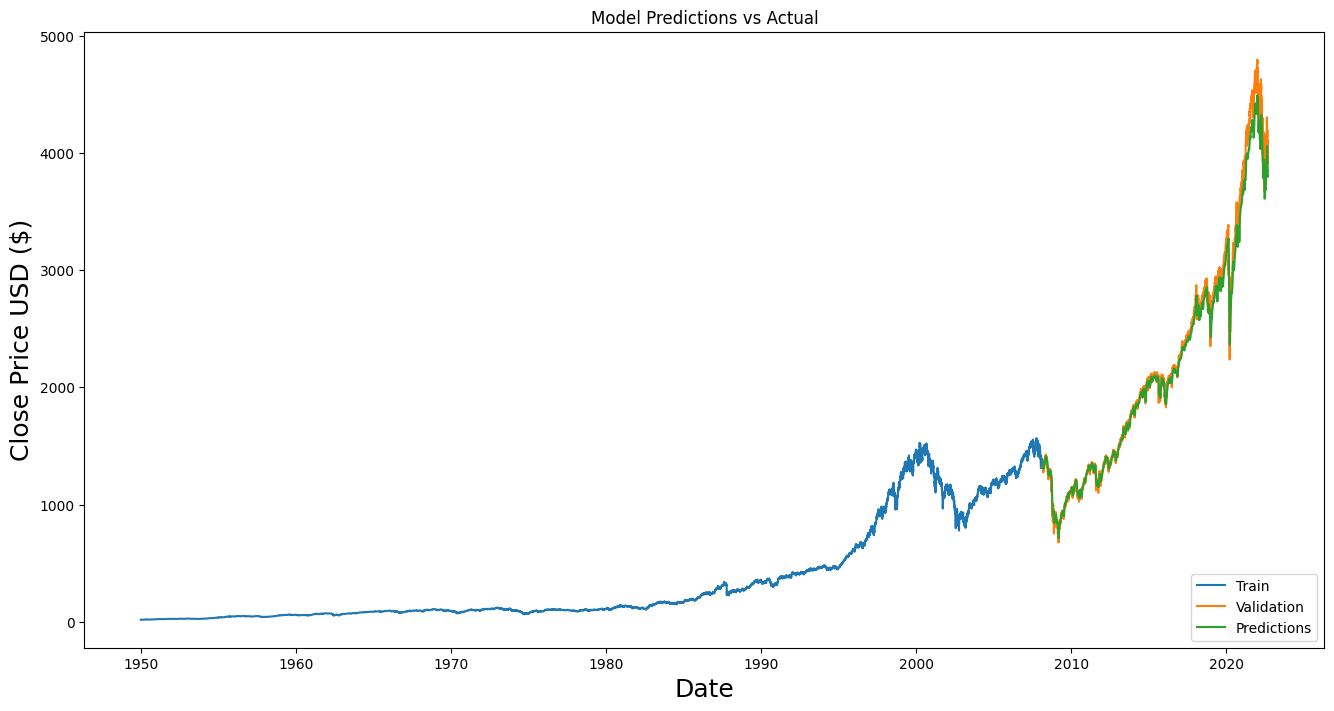

                  Close  Predictions
Date                                
2008-03-04  1326.750000  1361.107544
2008-03-05  1333.699951  1356.572266
2008-03-06  1304.339966  1352.143311
2008-03-07  1293.369995  1345.627563
2008-03-10  1273.369995  1337.564575
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Predicted next day close: $3816.15


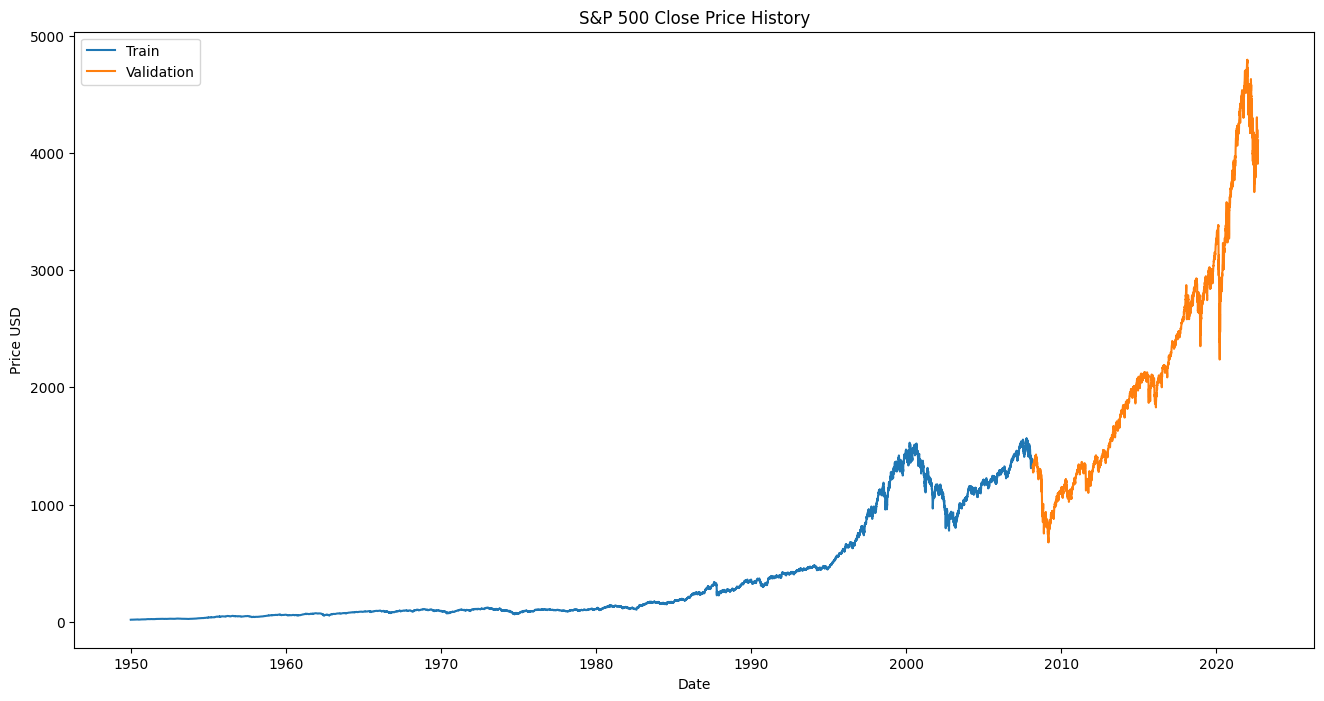

In [ ]:
# ===============================
# 1️⃣ Imports & Setup
# ===============================
import os
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import random
import tensorflow as tf
from pathlib import Path

cwd = Path.cwd()
REPO_ROOT = cwd if (cwd / "data" / "sp500.csv").exists() else cwd.parents[0]

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)



# ===============================
# 2️⃣ Data Loading & Preprocessing
# ===============================
def load_and_preprocess_data(seq_length=60):   
    """
    Fetch historical stock data and preprocess for LSTM training.
    Returns: x_train, y_train, scaled_data, training_data_len, scaler, raw data
    """
    # Load CSV
    csv_path = REPO_ROOT / "data" / "sp500.csv"
    df = pd.read_csv(csv_path, parse_dates=["Date"])
    df = df.set_index("Date").sort_index()

    if "Close" not in df.columns:
        raise ValueError("Missing required column: Close")
    if not df.index.is_monotonic_increasing:
        raise ValueError("Date index is not sorted increasing")




    print("Fetched data shape:", df.shape)
    
    # Optional plot of historical close prices
    plt.figure(figsize=(16,8))
    plt.title('Close Price History')
    plt.plot(df['Close'])
    plt.grid(True)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    plt.show()
    
    # Keep only 'Close' prices
    data = df.filter(['Close'])
    dataset = data.values
    training_data_len = math.ceil(len(dataset) * 0.8)
    
    # Scale data to 0-1
    scaler = MinMaxScaler(feature_range=(0, 1))
    
    # Prepare sequences
    train_dataset = dataset[:training_data_len]
    scaler.fit(train_dataset)

    scaled_data = scaler.transform(dataset)

    train_data = scaled_data[:training_data_len]

    x_train, y_train = [], []
    for i in range(seq_length, len(train_data)):
        x_train.append(train_data[i-seq_length:i, 0])
        y_train.append(train_data[i, 0])
    
    # Convert to arrays
    x_train, y_train = np.array(x_train), np.array(y_train)
    # Reshape for LSTM [samples, timesteps, features]
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    
    return x_train, y_train, scaled_data, training_data_len, scaler, data

# Load and preprocess
x_train, y_train, scaled_data, training_data_len, scaler, data = load_and_preprocess_data()

# ===============================
# 3️⃣ Build & Train LSTM Model
# ===============================
def build_and_train_model(x_train, y_train, epochs=5, batch_size=32):
    """
    Build a 2-layer LSTM model and train.
    """
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dense(units=25))
    model.add(Dense(units=1))
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)
    
    return model

# Train the model
model = build_and_train_model(x_train, y_train)

# ===============================
# 4️⃣ Evaluate & Visualize
# ===============================
def evaluate_and_visualize(model, scaled_data, training_data_len, seq_length=60, scaler=None, data=None):
    """
    Evaluate predictions and visualize results.
    """
    # Prepare test data
    test_data = scaled_data[training_data_len - seq_length:, :]
    x_test = []
    y_test = data.values[training_data_len:, :]
    
    for i in range(seq_length, len(test_data)):
        x_test.append(test_data[i-seq_length:i, 0])
    
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    
    # Make predictions
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)
    
    # Compute RMSE and MAE
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    print(f"Test RMSE: {rmse}")
    
    mae = np.mean(np.abs(predictions - y_test))
    print(f"Test MAE: {mae}")

    # Naive baseline: predict last observed close from the input window
    naive_preds = y_test.copy()
    naive_preds[0:] = data.values[training_data_len-1:-1]  # shift by 1 day
    naive_rmse = np.sqrt(mean_squared_error(y_test, naive_preds))
    print(f"Naive Baseline RMSE: {naive_rmse}")

    # Plot predictions
    train = data[:training_data_len]
    valid = data[training_data_len:].copy()
    valid['Predictions'] = predictions
    
    plt.figure(figsize=(16,8))
    plt.title('Model Predictions vs Actual')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    plt.plot(train['Close'])
    plt.plot(valid[['Close', 'Predictions']])
    plt.legend(['Train', 'Validation', 'Predictions'], loc='lower right')
    
    # Ensure results/plots folder exists
    plots_dir = os.path.join("results", "plots")
    os.makedirs(plots_dir, exist_ok=True)
    plt.savefig(os.path.join(plots_dir, "actual_vs_predicted.png"), dpi=200, bbox_inches="tight")
    plt.show()
    
    # Print validation dataframe
    print(valid.head())
    
    # Future price prediction
    new_df = data.filter(['Close'])
    last_60_days = new_df[-60:].values
    last_60_days_scaled = scaler.transform(last_60_days)
    
    X_test = np.array([last_60_days_scaled])
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    pred_price = model.predict(X_test)
    pred_price = scaler.inverse_transform(pred_price)
    print("Note: next-step prediction is for demonstration only, not trading advice.")
    print(f"Predicted next day close: ${pred_price[0][0]:.2f}")
    

# Run evaluation
evaluate_and_visualize(model, scaled_data, training_data_len, scaler=scaler, data=data)

# ===============================
# 5️⃣ Optional: Plot Full Close Prices
# ===============================
plt.figure(figsize=(16,8))
plt.plot(data['Close'][:training_data_len], label='Train')
plt.plot(data['Close'][training_data_len:], label='Validation')
plt.title("S&P 500 Close Price History")
plt.xlabel("Date")
plt.ylabel("Price USD")
plt.legend()
plt.show()
